### Сигналы и их обработка

In [ ]:
# !pip install soundfile
# !pip install torchaudio-filters

  Using cached soundfile-0.13.1-py2.py3-none-manylinux_2_28_x86_64.whl.metadata (16 kB)
  Using cached cffi-1.17.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
Using cached soundfile-0.13.1-py2.py3-none-manylinux_2_28_x86_64.whl (1.3 MB)
Using cached cffi-1.17.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (479 kB)
Using cached pycparser-2.22-py3-none-any.whl (117 kB)
  Using cached scipy-1.15.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.15.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (40.2 MB)


In [3]:
import numpy as np

import torch
import torchaudio
import torchaudio_filters as tf

import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

### Аудио и цифровое аудио

Загрузим тестовый файл с записью моего голоса для проекта TTS

In [4]:
wav, sr = sf.read('01001.wav')

In [5]:
print(f"Sample rate: {sr}Hz")
print(f"Wav({len(wav)} samples):", wav)#wav is an np.array

Sample rate: 22050Hz
Wav(156065 samples): [-3.05175781e-05  0.00000000e+00  0.00000000e+00 ... -3.05175781e-05
 -6.10351562e-05 -9.15527344e-05]


In [6]:
#torch soundfile wrapper 
wav, sr = torchaudio.load('01001.wav')

Sample rate is part of the file metadata in 01001.wav

The waveform is exactly wav. This is a sequence of amplitudes in the range [-1, 1] of type float32 (32 bits) , it roughly depicts how the diaphragm of the speaker should respond on the playback.

It is though dependent on the file given: by default the amplitudes are stored in integer form, i.e. for instance

- [-32767, 32767] (16bit PCM16) or
- [-8388607,8388607] (24bit PCM24)

In practice soundfile, torchaudio and scipy.wavio transform amplitudes in float format setting the ceiling at 1.

As to the shape,

In [7]:
wav.shape

torch.Size([1, 156065])

The first dimension is number of channels.

- Mono means 1 channel -- used for instrumental and microphone recording, technical recordings and for simple playbacks like on a phone

- Stereo means 2 channels -- common thing, you commonly listen to music in this format.

What's inside the data?

In [8]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050, monoConvert: bool = False):
    """Plots the given waveform

    Args:
        wav (torch.Tensor): waveform (Nch, T) or (T,)
        sr (int, optional): sample rate. Defaults to 22050.
    """    
    if(monoConvert):
        # Average all channels
        if(len(wav.shape)>1):
            # Any to mono audio convertion
            wav = wav.mean(dim=0)
        
        _,ax = plt.subplots(figsize=(14, 4))
        ax.plot(np.arange(0,wav.shape[0]/sr,1/sr),wav, alpha=.7, c='green')
        ax.grid()
        ax.set_xlabel('Time, sec', size=20)
        ax.set_ylabel('Amplitude', size=20)
    else:
        nChannels = wav.shape[0]
        if(nChannels==1):
            _,ax = plt.subplots(figsize=(14, 4))
            ax.plot(np.arange(0,wav.shape[1]/sr,1/sr),wav[0,:], alpha=.7, c='green')
            ax.grid()
            ax.set_xlabel('Time, sec', size=20)
            ax.set_ylabel('Amplitude', size=20)
        else:
            _, axs = plt.subplots(nChannels,1,figsize=(14, 4*nChannels))
            for id,ax in enumerate(axs):
                ax.plot(np.arange(0,wav.shape[1]/sr,1/sr),wav[id,:], alpha=.7, c='green')
                ax.grid()
                ax.set_xlabel('Time, sec', size=20)
                ax.set_ylabel(f'Amplitude, Ch={id+1}', size=20)
        
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

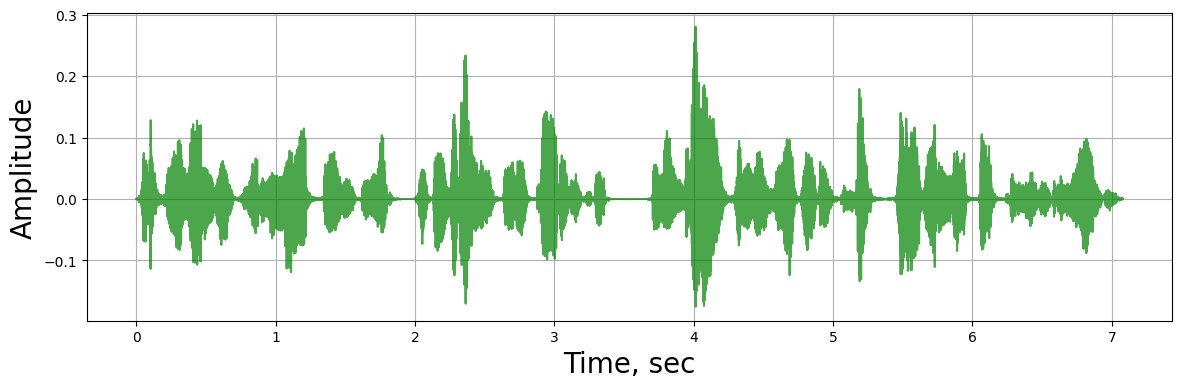

In [ ]:
visualize_audio(wav,sr) # np.concatenate([wav,wav*0.2],axis=0))

In [10]:
wav = torch.mean(wav,0,keepdim=True)

### Discrete Fourier Transform (DFT), Static Signal Representation

Познакомимся с [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) (Fast Fourier Transform)

We take the first 1024 samples and transform them. To get the right format of the spectrum below Nyquist frequency, we can use rfft and the size of the output spectrum will be n_fft // 2 + 1.

- [torch.fft - docs](https://pytorch.org/docs/stable/fft.html) - Дискретные преобразования Фурье и связанные с ними функции.
- [torch.fft.fft](https://pytorch.org/docs/stable/generated/torch.fft.fft.html#torch.fft.fft) - Вычисляет одномерное дискретное преобразование Фурье входных данных.
- [torch.fft.rfft](https://pytorch.org/docs/stable/generated/torch.fft.rfft.html#torch.fft.rfft) - Вычисляет одномерное преобразование Фурье для вещественных входных данных.

In [12]:
nFFT = 1024
# подсчитаем спектр
spectrum = torch.fft.fft(wav,n=nFFT) # compute DFT with torch.fft (FFT)
spectrumR = torch.fft.rfft(wav,n=nFFT) # compute DFT with torch.fft (RFFT)

In [15]:
print(f"spectrum.dtype={spectrum.dtype}, spectrumR.dtype={spectrumR.dtype},")
print(f"spectrum.shape={spectrum.shape}, spectrumR.shape={spectrumR.shape}")

spectrum.dtype=torch.complex64, spectrumR.dtype=torch.complex64,
spectrum.shape=torch.Size([1, 1024]), spectrumR.shape=torch.Size([1, 513])


In [17]:
freqs = np.arange(0,nFFT)/nFFT*sr # compute the frequencies (FFT)
freqsR = np.arange(0, nFFT//2 + 0.0001)/nFFT*sr # compute the frequencies (RFFT)
print(f"freqs.shape={freqs.shape}, freqsR.shape={freqsR.shape}")

freqs.shape=(1024,), freqsR.shape=(513,)


Fourier transform gives a static signal representation. We just measure all the frequency component in the whole signal.

From it we can compute a power spectrum and observe which frequency components were presented in the signal and what was their strength. The longer the signal, the better the frequency resolution.

Преобразование Фурье дает статическое представление сигнала. Мы просто измеряем все частотные составляющие во всем сигнале.

Из него мы можем вычислить спектр мощности и проследить, какие частотные компоненты были представлены в сигнале и какова была их сила. Чем длиннее сигнал, тем лучше частотное разрешение.

In [18]:
powerSpectrum = spectrum.abs()**2
powerSpectrumR = spectrumR.abs()**2

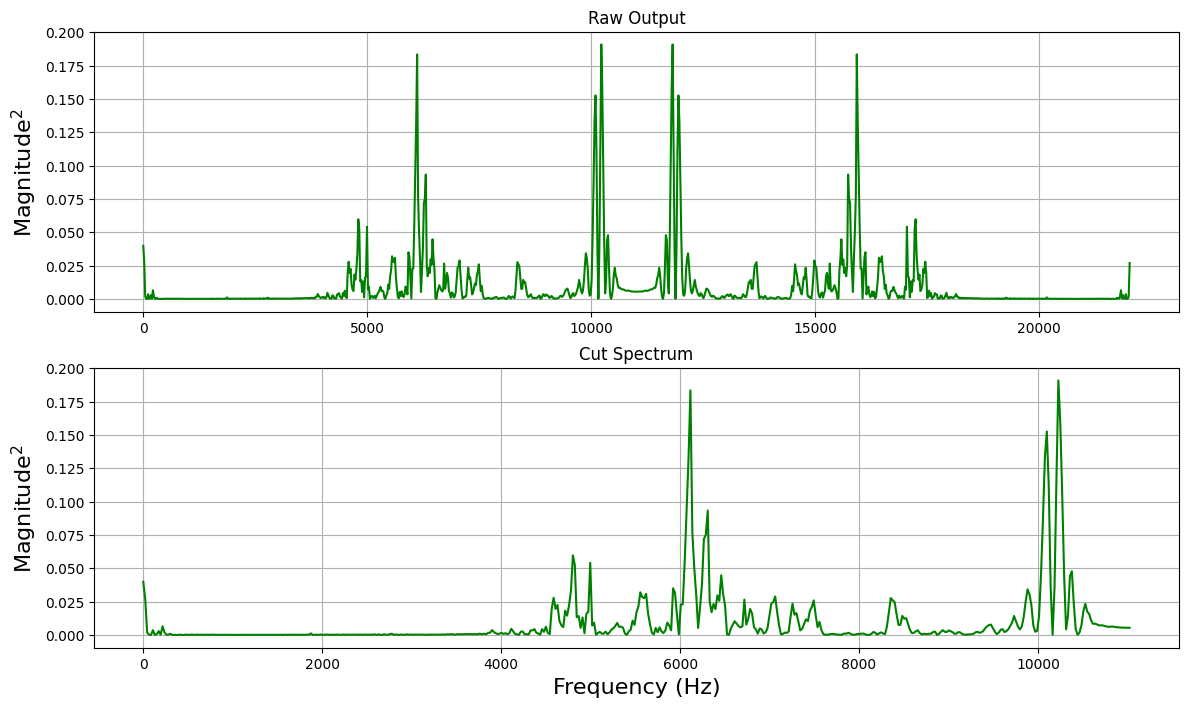

In [19]:
f,(ax1,ax2) = plt.subplots(2,1,figsize=(14, 8))

ax1.grid()
ax1.set_title("Raw Output")
ax1.plot(freqs, powerSpectrum.squeeze(), c='green')
ax1.set_ylabel('Magnitude$^2$', size=16)

ax2.grid()
ax2.set_title("Cut Spectrum")
ax2.plot(freqsR, powerSpectrumR.squeeze(), c='green')
ax2.set_xlabel('Frequency (Hz)', size=16)
ax2.set_ylabel('Magnitude$^2$', size=16)
plt.show()

For better visual quality in audio engineering people often consider taking various Mel-scales like


in frequency scale and dB scale like


in power measurements. The decibel scale is relative, i.e. it shows how signal magnitude differs on a logarithmic scale from the reference point. In AES 17 standard and DAWs the dBFS (decibel to full scale) scale is used:


markdown
For better visual quality in audio engineering people often consider taking various Mel-scales like:

$$\ m = 2595 * log_{10}(1 + f/700) $$

in frequency scale and dB scale like:


$$\ P_{dB} = 10 * log_{10}(P/Po) $$


in power measurements. The decibel scale is **relative**, i.e. it shows how signal magnitude differs on a logarithmic scale from the reference point. In AES 17 standard and DAWs the dBFS (decibel to full scale) scale is used:


$$\ P_{dBFS} = 10 * log_{10}(P)$$



/tmp/ipykernel_19621/4130932232.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 10*np.log10(p/p0)
/tmp/ipykernel_19621/4130932232.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595*np.log10(1 + f/700) #wikipedia suggestion


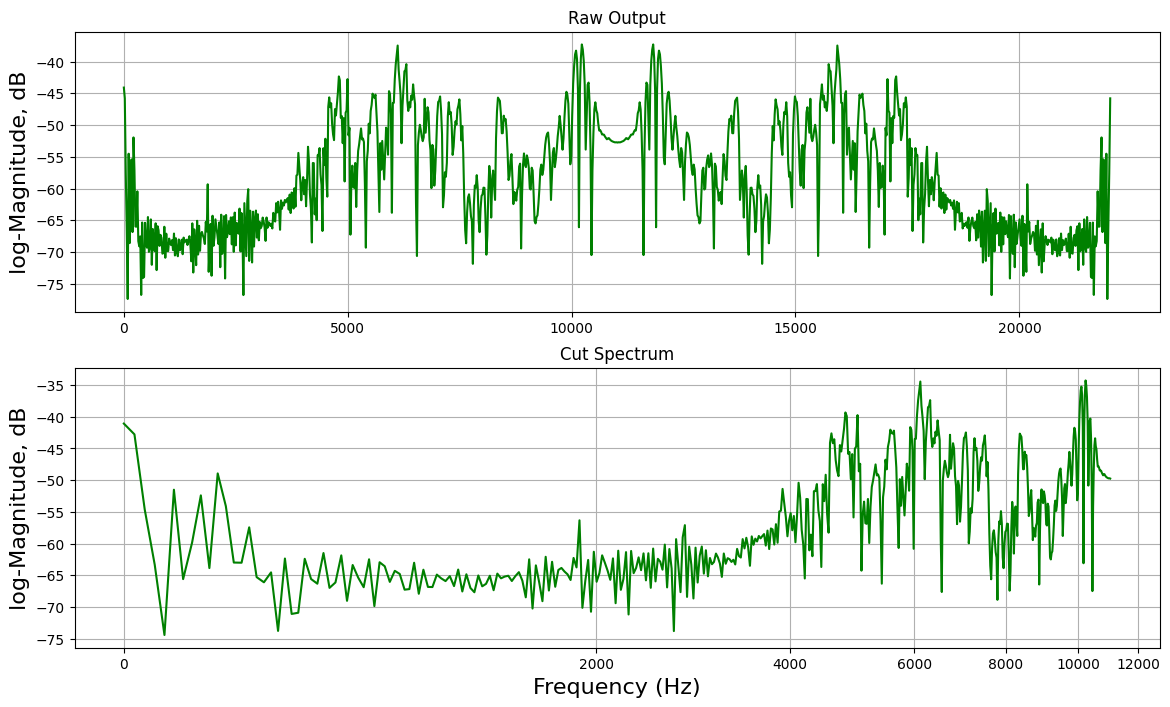

In [21]:
def melForward(f):
    return 2595*np.log10(1 + f/700) #wikipedia suggestion
def melInverse(m):
    return (10**(m/2595)-1)*700

p0=1 #dBFS, usually FAR MORE than any possible p you can encounter. If waveform in 0,1, it should be 1(AES17)

def dBForward(p):
    return 10*np.log10(p/p0)
def dBInverse(pdB):
    return 10**(pdB*10)*p0

f,(ax1,ax2) = plt.subplots(2,1,figsize=(14, 8))

ax1.grid()
ax1.set_title("Raw Output")
ax1.plot(freqs, dBForward(powerSpectrum.squeeze()/powerSpectrum.shape[-1]), c='green')
ax1.set_ylabel('log-Magnitude, dB', size=16)       
#ax1.set_xscale("function", functions=(melForward,melInverse))

ax2.grid()
ax2.set_title("Cut Spectrum")
ax2.plot(freqsR, dBForward(2*powerSpectrumR.squeeze()/powerSpectrum.shape[-1]), c='green')
ax2.set_xlabel('Frequency (Hz)', size=16)
ax2.set_ylabel('log-Magnitude, dB', size=16)             
ax2.set_xscale("function", functions=(melForward,melInverse))
plt.show()

If we are talking about STFT, short signal frames (512,1024,2048) are commonly used for FFT and there are aliasing and leakage effects.

Let's look at the example.

Если мы говорим о STFT, то для БПФ обычно используются короткие кадры сигнала (512,1024,2048), и возникают эффекты алиасинга и утечки.

Давайте рассмотрим пример.

То есть мы указываем частоту 1100, которой нет в нашем сигнале и преобразование фурье, нам показывает на 900. Хотя на самом деле с точки зрения физике частоты 1100 не было.

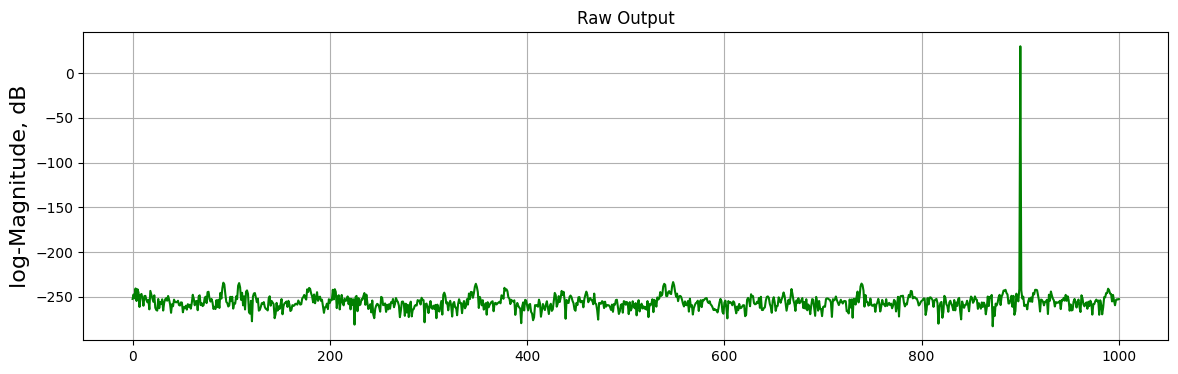

In [28]:
xs = np.sin(2*np.pi*np.arange(0,1,1/2000)*1100) #sr=2kHz
xsSpectrum = np.abs(np.fft.rfft(xs))**2 #compute power spectrum
xsFreqs = np.arange(0, len(xs)//2 + 0.0001)/len(xs)*2000 #compute the frequencies

f,ax1 = plt.subplots(figsize=(14, 4))

ax1.grid()
ax1.set_title("Raw Output")
ax1.plot(xsFreqs, dBForward(xsSpectrum.squeeze()/xsSpectrum.shape[-1]), c='green')
ax1.set_ylabel('log-Magnitude, dB', size=16)    
plt.show()   

To mitigate it, a window is used, we'll use Hann window function.

Чтобы смягчить это, используется окно, мы будем использовать функцию окна Hann.

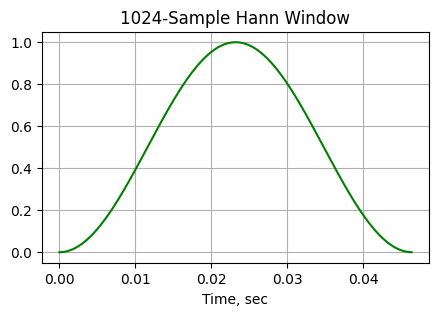

In [29]:
windowSize = nFFT
window = torch.hann_window(windowSize)

f,ax = plt.subplots(figsize=(5, 3))
ax.grid()
ax.set_title("1024-Sample Hann Window")
ax.plot(np.arange(0,nFFT)/sr,window, c='green')
ax.set_xlabel("Time, sec")
plt.show()

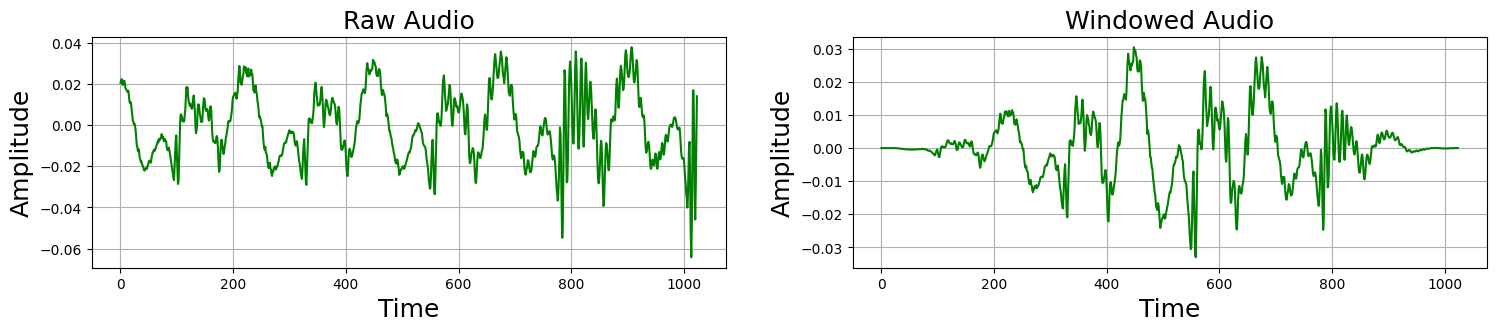

In [30]:
wavClipped = wav[:,20*windowSize:21*windowSize]
wavClippedWindowed = window * wavClipped

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 3))

ax1.plot(wavClipped.squeeze(), c='green')
ax1.grid()
ax1.set_title('Raw Audio', size=18)
ax1.set_xlabel('Time', size=18)
ax1.set_ylabel('Amplitude', size=18)

ax2.grid()
ax2.plot(wavClippedWindowed.squeeze(), c='green')
ax2.set_title('Windowed Audio', size=18)
ax2.set_xlabel('Time', size=18)
ax2.set_ylabel('Amplitude', size=18)
plt.show()

/tmp/ipykernel_19621/4130932232.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 10*np.log10(p/p0)


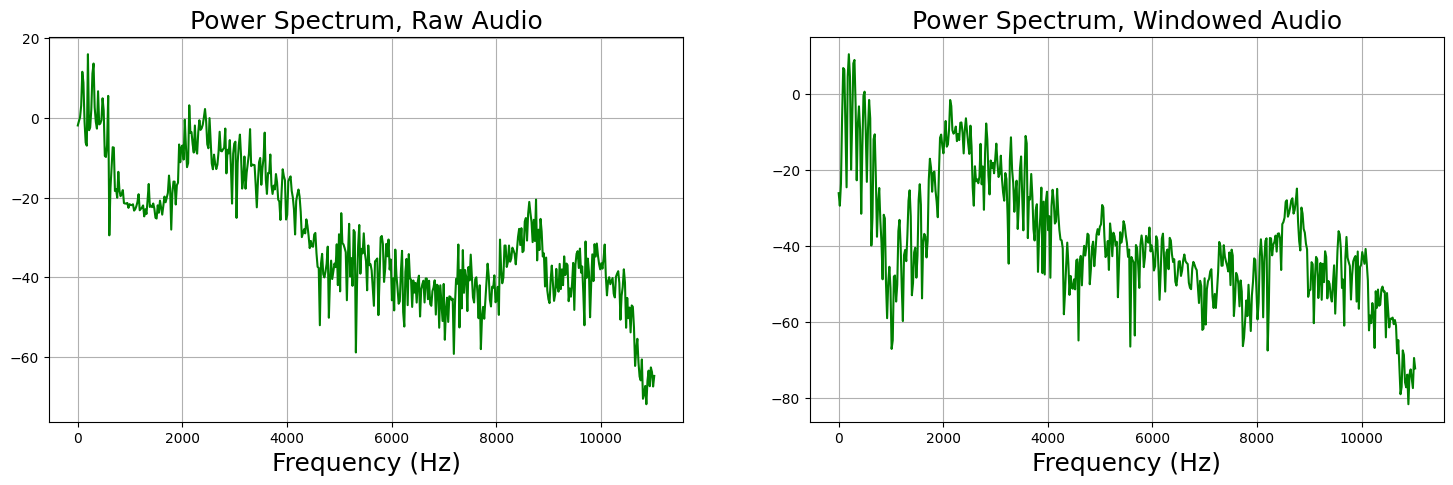

In [31]:
spectrum = torch.fft.rfft(wavClipped).abs().pow(2)
spectrumWindowed = torch.fft.rfft(wavClippedWindowed).abs().pow(2)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.grid()
ax1.plot(freqsR,dBForward(spectrum.squeeze()), c='green')
ax1.set_title('Power Spectrum, Raw Audio', size=18)
ax1.set_xlabel('Frequency (Hz)', size=18)

ax2.grid()
ax2.plot(freqsR, dBForward(spectrumWindowed.squeeze()), c='green')
ax2.set_title('Power Spectrum, Windowed Audio', size=18)
ax2.set_xlabel('Frequency (Hz)', size=18)
    
plt.show()

### [STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (Short-time Fourier transform)

Let's put it all together and apply STFT (Short-time Fourier transform)

In [ ]:
nFFT = 1024
windowSize = nFFT # размер окна
hopSize = 256 # сдвиг окна за 1 шаг
window = torch.hann_window(nFFT)

In [34]:
stft = torch.stft(
    wav,
    n_fft=nFFT,
    hop_length=hopSize,
    win_length=windowSize,
    window=window,
    
    # We don't want to center input signal for padding
    center=False,
    
    # Take first (n_fft // 2 + 1) frequencies, before Nyquist
    onesided=True,
    
    #Get complex numbers
    return_complex=True 
)

In [35]:
stft.shape

torch.Size([1, 513, 606])

In [36]:
print(sr)
freqsR = np.arange(0,nFFT/2+0.0001)/(nFFT)*sr
print(freqsR.shape)
logSpectrogram = 20*torch.log10(stft.abs()/ window.sum()) 
logSpectrogram.shape

22050
(513,)


torch.Size([1, 513, 606])

The last dimension of spectrogram is time. Each timestamp is called frame Now let's visualize the spectrogram for the whole wav.

Последнее измерение спектрограммы - время. Каждая временная метка называется кадром Теперь давайте визуализируем спектрограмму для всего wav.

11025.0
(513, 606) (513, 606) torch.Size([1, 513, 606])
tensor(-25.9399)


/tmp/ipykernel_19621/4130932232.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595*np.log10(1 + f/700) #wikipedia suggestion


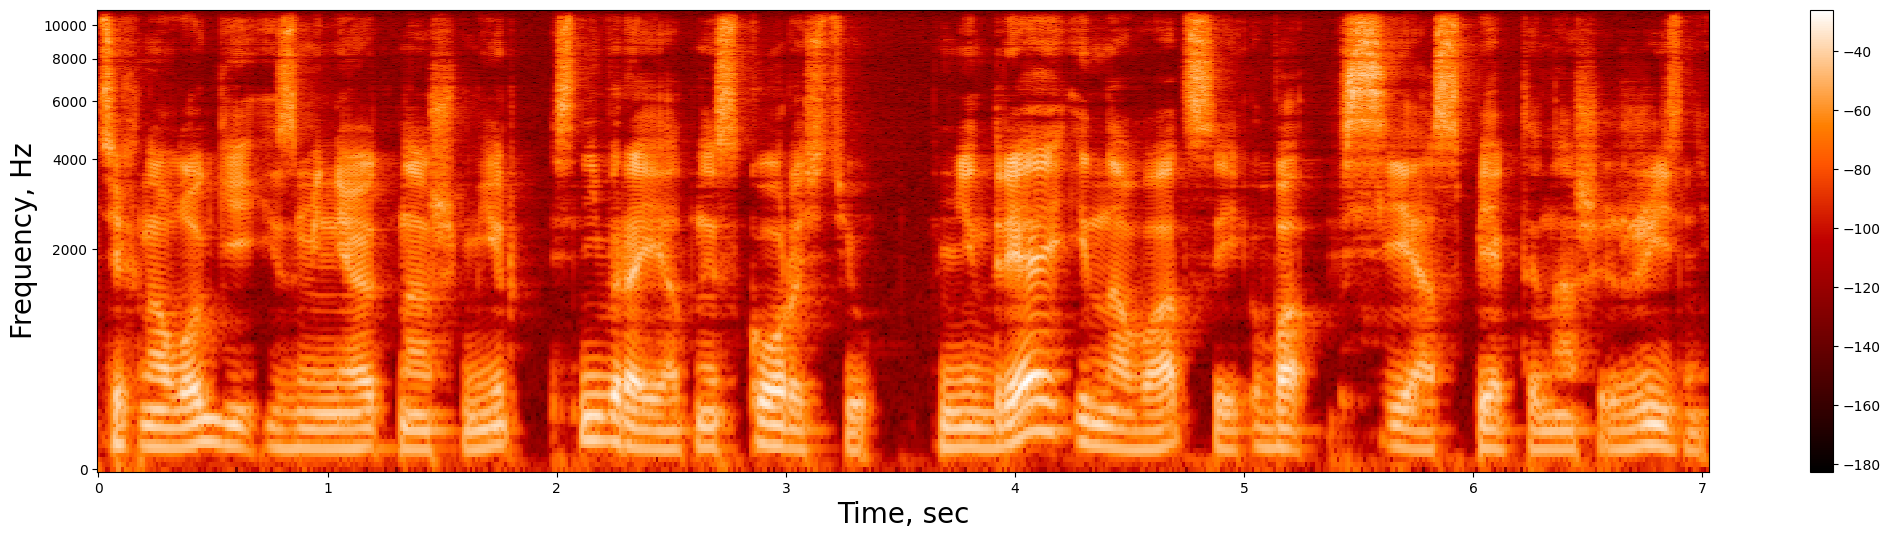

In [37]:
f,ax = plt.subplots(figsize=(26, 6))

tGrid = np.arange(0,logSpectrogram.shape[2]*hopSize, hopSize)/sr
fGrid = freqsR
print(freqsR[-1])
tt,ff = np.meshgrid(tGrid,fGrid)
print(tt.shape,ff.shape,logSpectrogram.shape)
print(torch.max(logSpectrogram))
im=ax.pcolormesh(tt,ff,logSpectrogram.squeeze(),cmap="gist_heat",antialiased=True)
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, Hz', size=20)
ax.set_yscale("function",functions=(melForward,melInverse))
f.colorbar(im)
plt.show()

### Mel Spectrogram

The last stage is Mel Spectrogram.

To initialise Mel Scaler we will use torchaudio.

In [42]:
nMels=10
mel_scaler = torchaudio.transforms.MelScale(
    n_mels=nMels,
    sample_rate=sr,
    n_stft=nFFT // 2 + 1
)
print(mel_scaler.fb.shape)

torch.Size([513, 10])


Mel Scaler is nothing more than rectangle matrix. We will multiply each frame in spectrogram by mel_scaler.fb matrix.

Mel Scaler - это не что иное, как прямоугольная матрица. Мы будем умножать каждый кадр в спектрограмме на матрицу mel_scaler.fb.

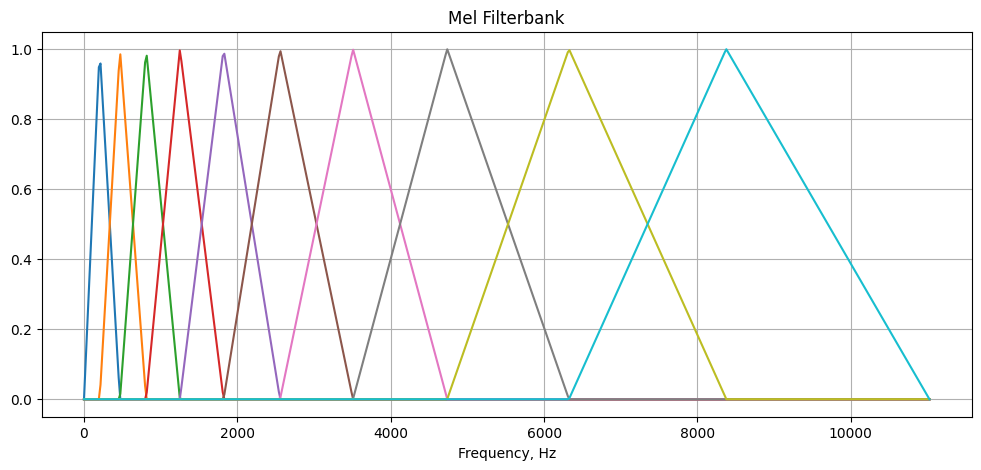

In [43]:
f,ax = plt.subplots(figsize=(12,5))

ax.grid()
ax.set_title("Mel Filterbank")
ax.set_xlabel("Frequency, Hz")
ax.plot(freqsR,mel_scaler.fb)
plt.show()

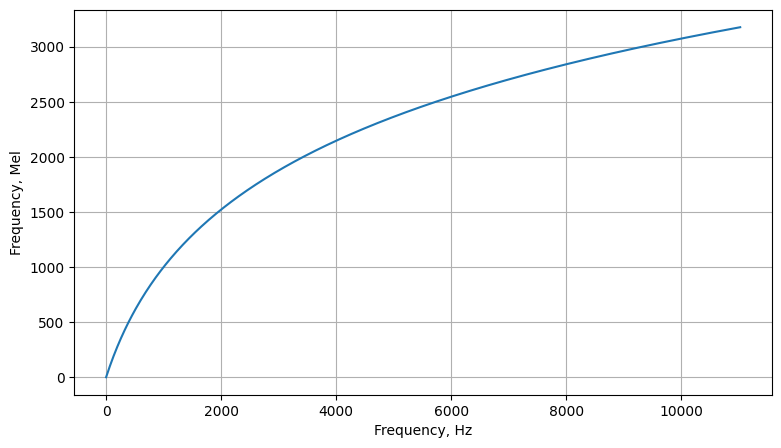

In [44]:
f,ax = plt.subplots(figsize=(9,5))

ax.grid()
ax.set_xlabel("Frequency, Hz")
ax.set_ylabel("Frequency, Mel")
ax.plot(freqsR, melForward(freqsR))
plt.show()

In [45]:
melSpectrogram = 20*torch.log10(mel_scaler(torch.abs(stft))) #magnitude spectrogram in dBFS

In [46]:
melSpectrogram.shape

torch.Size([1, 10, 606])

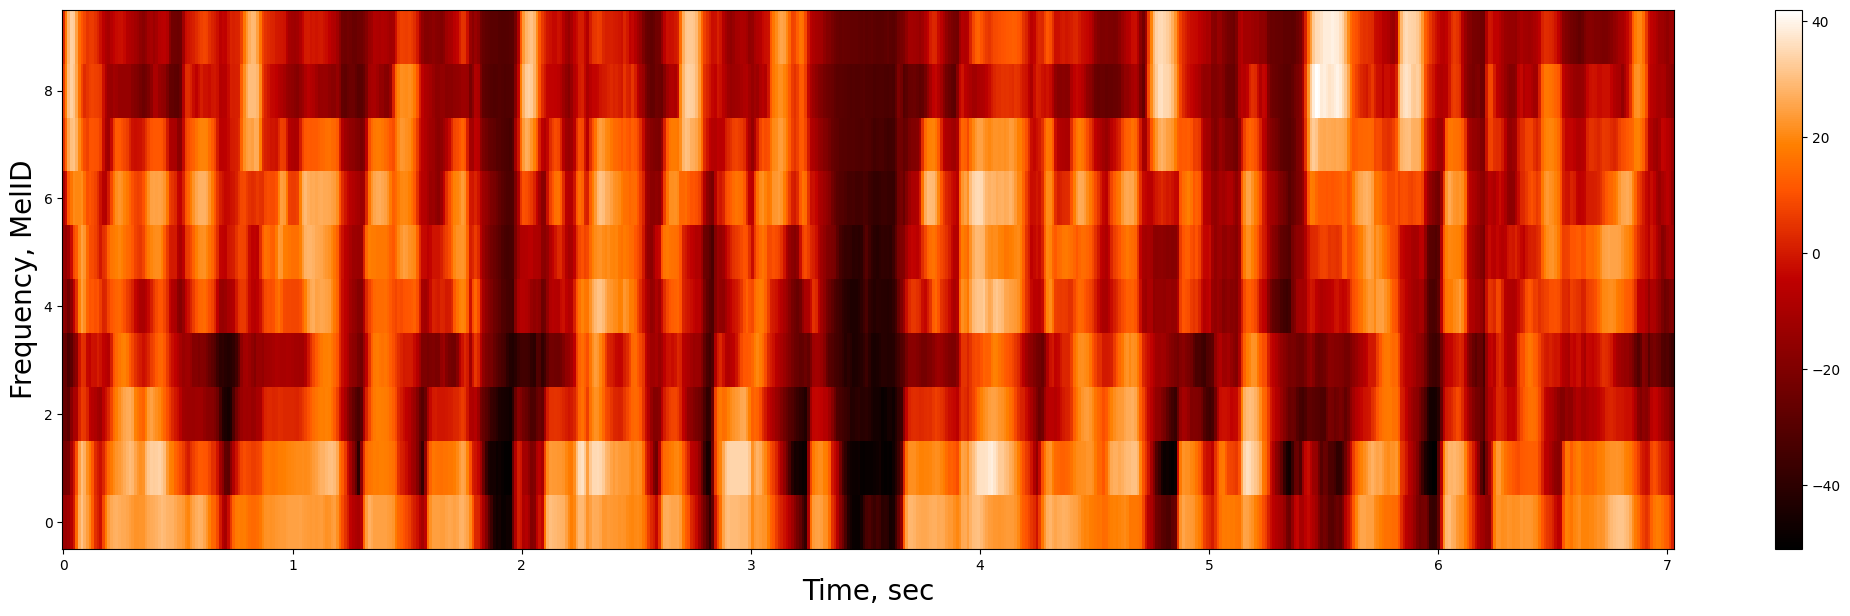

In [47]:
f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,melSpectrogram.shape[2]*hopSize, hopSize)/sr
fGrid = np.arange(nMels)
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff,melSpectrogram.squeeze(),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, MelID', size=20)
f.colorbar(im)
plt.show()

### Built-in Spectrograms in PyTorch

In general, we can use MelSpectrogram from torchaudio which combine window, stft, spectrogram and mel calculation. This simplifies usage of spectrograms in the pipelines.

В общем случае мы можем использовать MelSpectrogram из torchaudio, который объединяет вычисление window, stft, spectrogram и mel. Это упрощает использование спектрограмм в конвейерах.

In [48]:
melspecTransform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_fft=nFFT,
    win_length=windowSize,
    hop_length=hopSize,
    n_mels=nMels,
    window_fn=torch.hann_window,
    center=False
)

Common Spectrogram is also available.

In [49]:
specTransform = torchaudio.transforms.Spectrogram(
    n_fft=nFFT,
    win_length=windowSize,
    hop_length=hopSize,
    window_fn=torch.hann_window,
    center=False
)

In [50]:
spec = specTransform(wav)
specMel = melspecTransform(wav)
print(spec.dtype,spec.shape)
print(specMel.dtype,specMel.shape)

torch.float32 torch.Size([1, 513, 606])
torch.float32 torch.Size([1, 10, 606])


/tmp/ipykernel_19621/4130932232.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595*np.log10(1 + f/700) #wikipedia suggestion


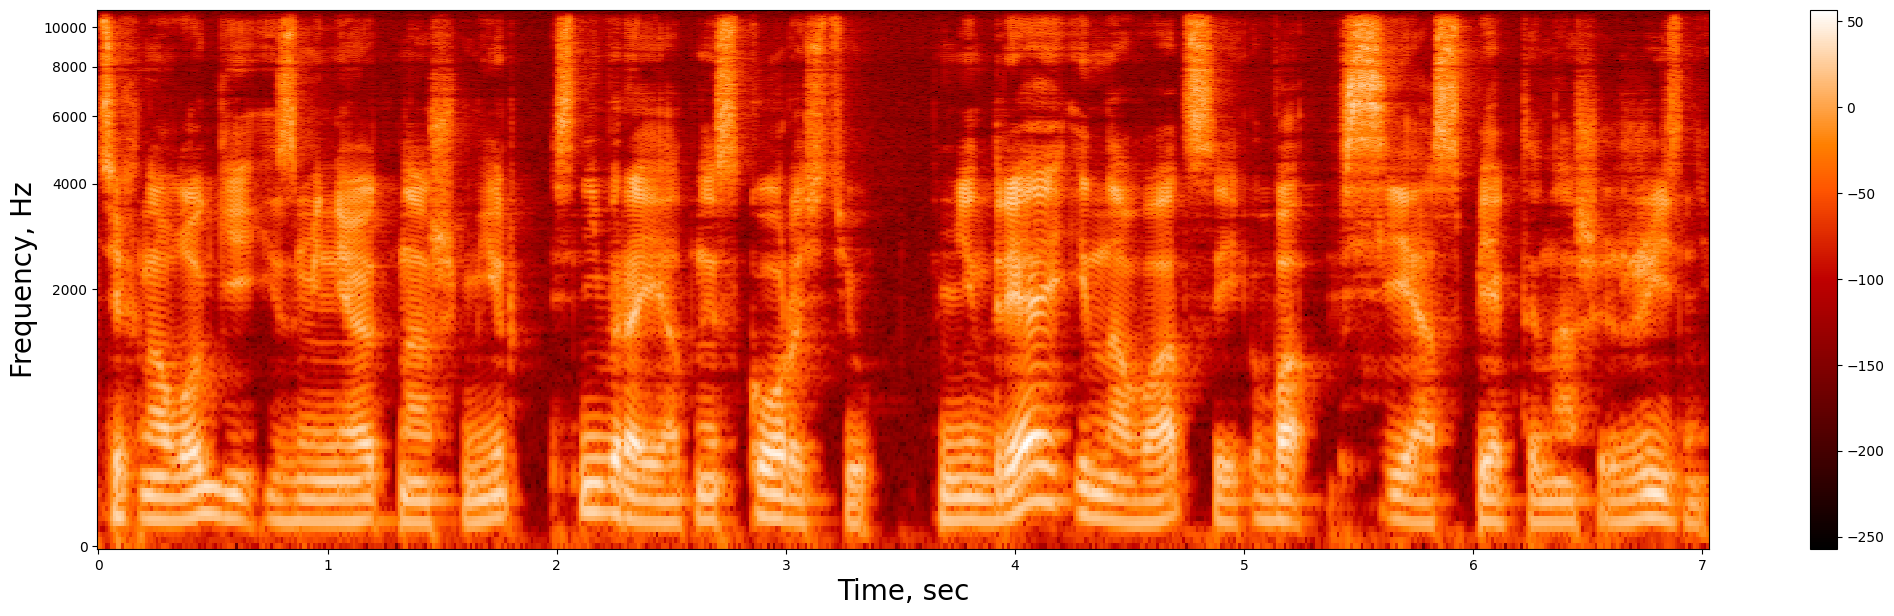

In [51]:
f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,spec.shape[2]*hopSize, hopSize)/sr
fGrid = freqsR
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff,20*torch.log10(spec.squeeze()),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, Hz', size=20)
ax.set_yscale("function",functions=(melForward,melInverse))
f.colorbar(im)
plt.show()

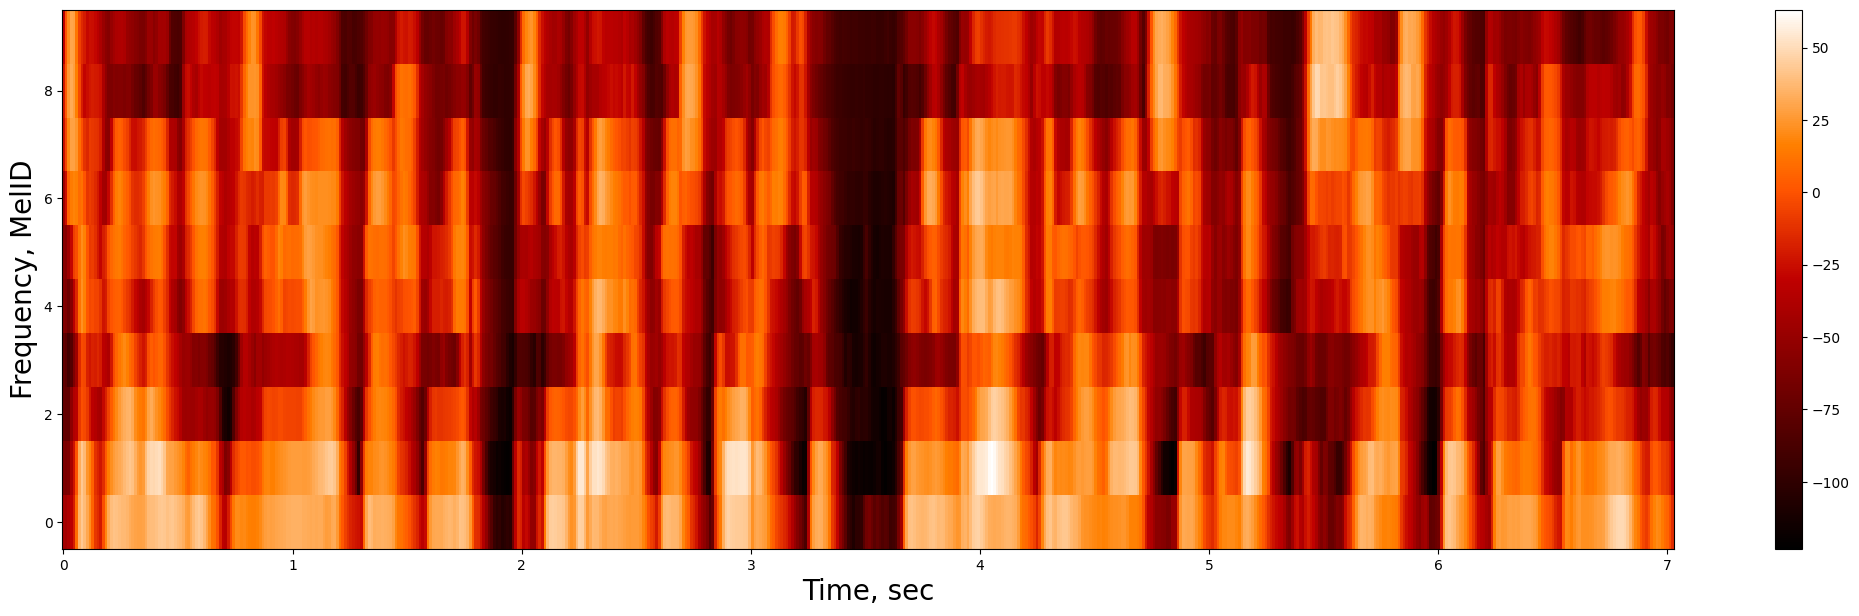

In [52]:
f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,specMel.shape[2]*hopSize, hopSize)/sr
fGrid = np.arange(nMels)
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff, 20*torch.log10(specMel.squeeze()),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, MelID', size=20)
f.colorbar(im)
plt.show()

### More things: Impulse Response

Impulse response is a very powerful modelling idea used in various audio effects. The theory is the following.

*   There is clean signal $\ x(t) $ (can be analogue, i.e. continuous, or digital, discrete)
*   It is processed by the environment (acoustics, instrumental stack, FX stack.....) and
*   Processed signal is $\ y(t) $ is given as the output.

For example, acoustic FX like reverberation could be modelled as

$$\ y(t) = (x * h)(t) $$

convolution kernel $h(t)$ is called system Impulse Response (IR) function.

There are various types of IR functions available on the internet, let's try one and see what's inside.


Импульсная характеристика - это очень мощная идея моделирования, используемая в различных аудиоэффектах. Теория заключается в следующем.

* Имеется чистый сигнал $\ x(t) $ (может быть аналоговым, т.е. непрерывным, или цифровым, дискретным)
* Он обрабатывается окружающей средой (акустикой, инструментальным стеком, стеком FX.....) и
* Обработанный сигнал $\ y(t) $ подается как выход.

Например, акустический FX, такой как реверберация, может быть смоделирован как

$$\ y(t) = (x * h)(t) $$

Ядро свертки $h(t)$ называется функцией импульсного отклика системы (IR).

В интернете можно найти различные типы IR-функций, давайте попробуем одну из них и посмотрим, что внутри.

In [68]:
irWav, irSR = torchaudio.load("./220752__jmuehlhans__impulse-response-church.wav")
resampleTransform = torchaudio.transforms.Resample(irSR, sr)
irWav = resampleTransform(irWav)
spec = specTransform(irWav)
freqsR = np.arange(0, nFFT//2 + 0.001)/(nFFT)*sr

/tmp/ipykernel_19621/4130932232.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595*np.log10(1 + f/700) #wikipedia suggestion


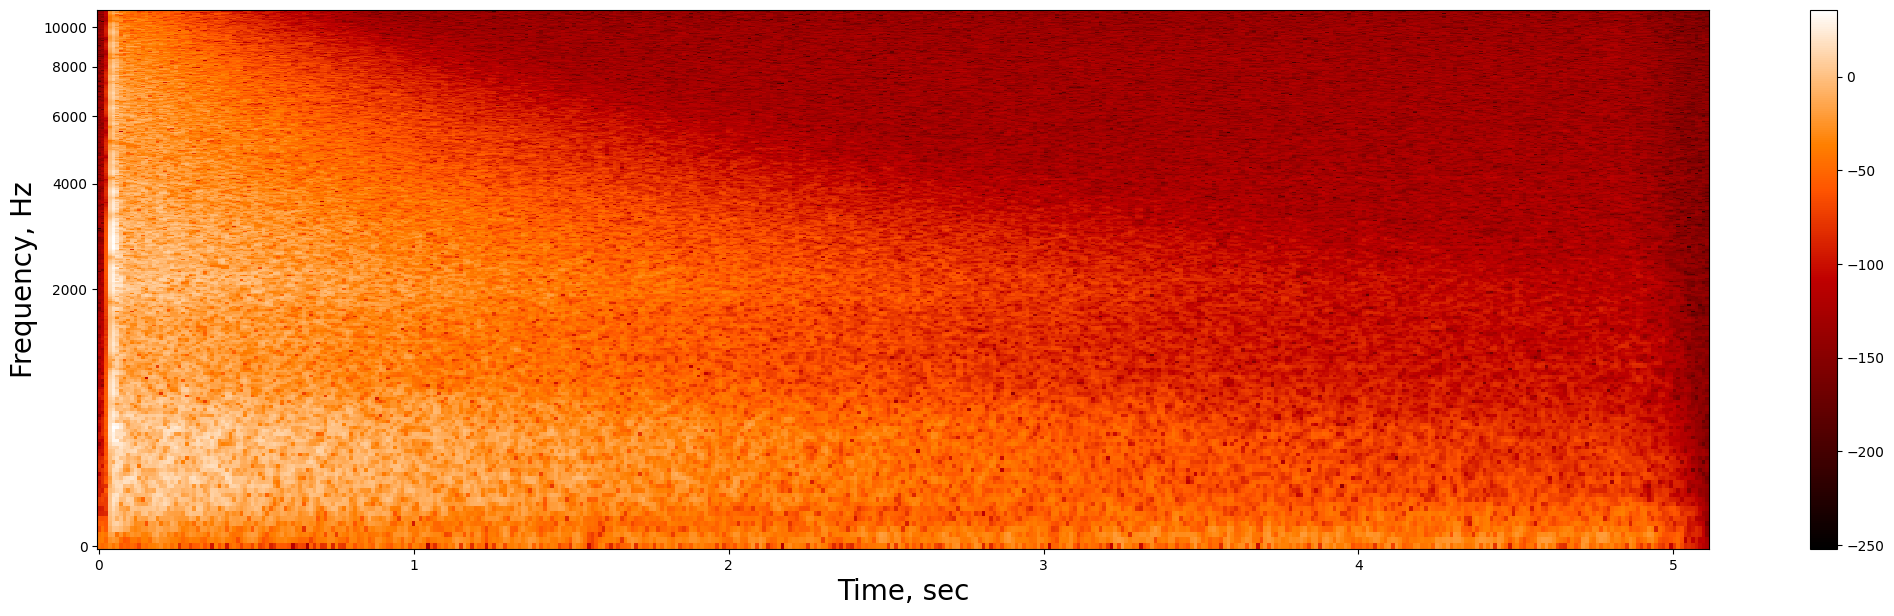

In [69]:
f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,spec.shape[2]*hopSize, hopSize)/sr
fGrid = freqsR
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff,20*torch.log10(spec.squeeze()),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, Hz', size=20)
ax.set_yscale("function",functions=(melForward,melInverse))
f.colorbar(im)
plt.show()

How does it sound?..

In [70]:
display.display(display.Audio(irWav, rate=sr))

In [71]:
wav, sr = torchaudio.load('01001.wav')
wav = torch.mean(wav,dim=0,keepdim=True)
convTransform = torchaudio.transforms.FFTConvolve()

In [72]:
wavProcessed = convTransform(wav,irWav)
wavProcessedSpec = specTransform(wavProcessed)

/tmp/ipykernel_19621/4130932232.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595*np.log10(1 + f/700) #wikipedia suggestion


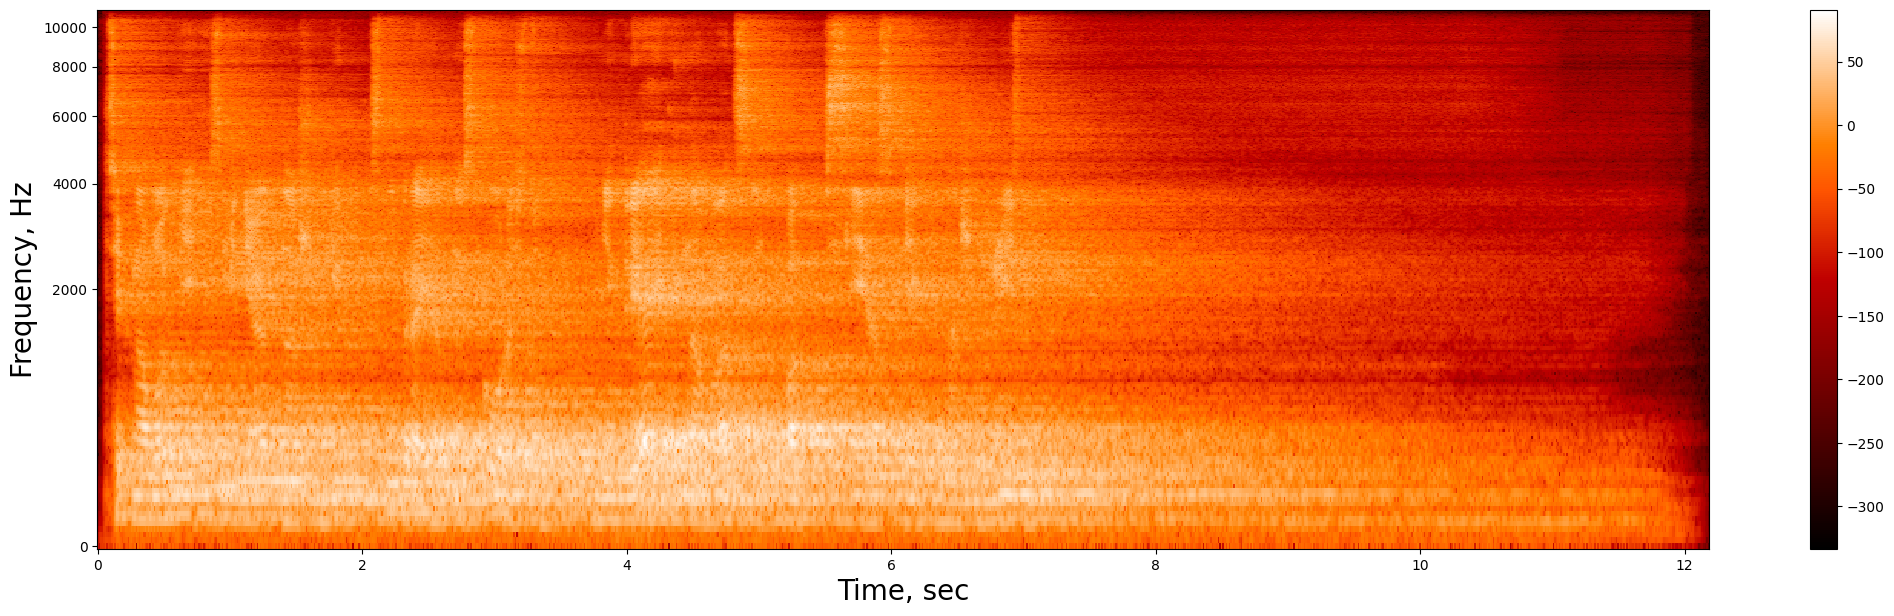

In [73]:
f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,wavProcessedSpec.shape[2]*hopSize, hopSize)/sr
fGrid = freqsR
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff,20*torch.log10(wavProcessedSpec.squeeze()),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, Hz', size=20)
ax.set_yscale("function",functions=(melForward,melInverse))
f.colorbar(im)
plt.show()

In [74]:
display.display(display.Audio(wavProcessed, rate=sr))

### Calculating Impulse Response from Scratch

Now that we see it really works, the natural question arises: how do we obtain these impulse responses (IRs)? This is where functional calculus comes into play.  

Let's summarize what we know so far. If $ x(t) $ is the input signal and $ h(t) $ is the impulse response function of the environment, then the output is given by  


$$ y(t) = (h * x)(t) $$

Convolution is not limited to ordinary functions—it can also be performed with linear functionals from the dual space. Here are some notable examples:  

- **Probability measures.** Each probability measure defines a linear functional (mathematical expectation). Recall the convolution formula for the sum of independent random variables—that’s the convolution of probability distributions.  
- **Finite measures.** Similar to probability measures, but the total measure is not necessarily equal to 1.  
- **Schwartz distributions.** A well-known example is the Dirac delta function \( \delta \), which acts on functions as  

  $$ \delta_{x_0} f = f(x_0)$$

  A remarkable property of convolving a regular function with the delta function is that  

  $$ (f * \delta_0)(t) = f(t) $$

Thus, if we were to record the transformed effect of a $ \delta_0 $ signal at $ t = 0 $ as it propagates through the environment, we would obtain the impulse response function.  

Since the delta signal is modeled as an instantaneous short impulse, the resulting function is called the **Impulse Response function**.

Теперь, когда мы видим, что это действительно работает, возникает естественный вопрос: как получить эти импульсные ответы (IR)? Здесь на помощь приходит функциональное исчисление.  

Давайте подытожим то, что мы знаем до сих пор. Если $ x(t) $ - входной сигнал, а $ h(t) $ - функция импульсного отклика среды, то на выходе получается 


$$ y(t) = (h * x)(t) $$

Конволюция не ограничивается обычными функциями - она также может быть выполнена с линейными функциями из двойственного пространства. Вот несколько ярких примеров:  

- ** Вероятностные меры.** Каждая вероятностная мера определяет линейный функционал (математическое ожидание). Вспомните формулу свертки для суммы независимых случайных величин - это свертка распределений вероятностей.  
- **Конечные меры.** Аналогичны вероятностным мерам, но общая мера не обязательно равна 1. 
- **Распределения Шварца. ** Известным примером является дельта-функция Дирака \( \delta \), которая действует на функции как 

 $$ \delta_{x_0} f = f(x_0)$$

 Замечательным свойством свертки обычной функции с дельта-функцией является то, что 

 $$ (f * \delta_0)(t) = f(t) $$

Таким образом, если мы будем записывать преобразованное воздействие сигнала $ \delta_0 $ в $ t = 0 $ по мере его распространения через среду, мы получим функцию импульсного отклика.  

Поскольку дельта-сигнал моделируется как мгновенный короткий импульс, полученная функция называется **функцией импульсного отклика**.

#### Signal Filtering

In various applications including music the signals are filtered in many ways and one of most basic filters are EQ-filters. These are given in immense variety, let's look at some.

В различных приложениях, в том числе и в музыке, сигналы фильтруются различными способами, и одним из самых основных фильтров является эквалайзер. Они представлены в огромном разнообразии, давайте рассмотрим некоторые из них.

##### Low-pass 

Leaves lower frequencies(below cutoff) intact while supressing higher frequencies(above cutoff).

Оставляет нетронутыми низкие частоты (ниже среза), подавляя при этом высокие частоты (выше среза).

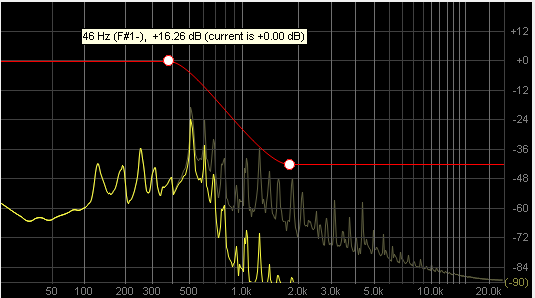

In [78]:
lowPassFilter = tf.LowPass(500,sr)
wavLP = lowPassFilter(wav)
wavLPSpec = specTransform(wavLP)

In [79]:
display.display(display.Audio(wavLP, rate=sr))

/tmp/ipykernel_19621/4130932232.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595*np.log10(1 + f/700) #wikipedia suggestion


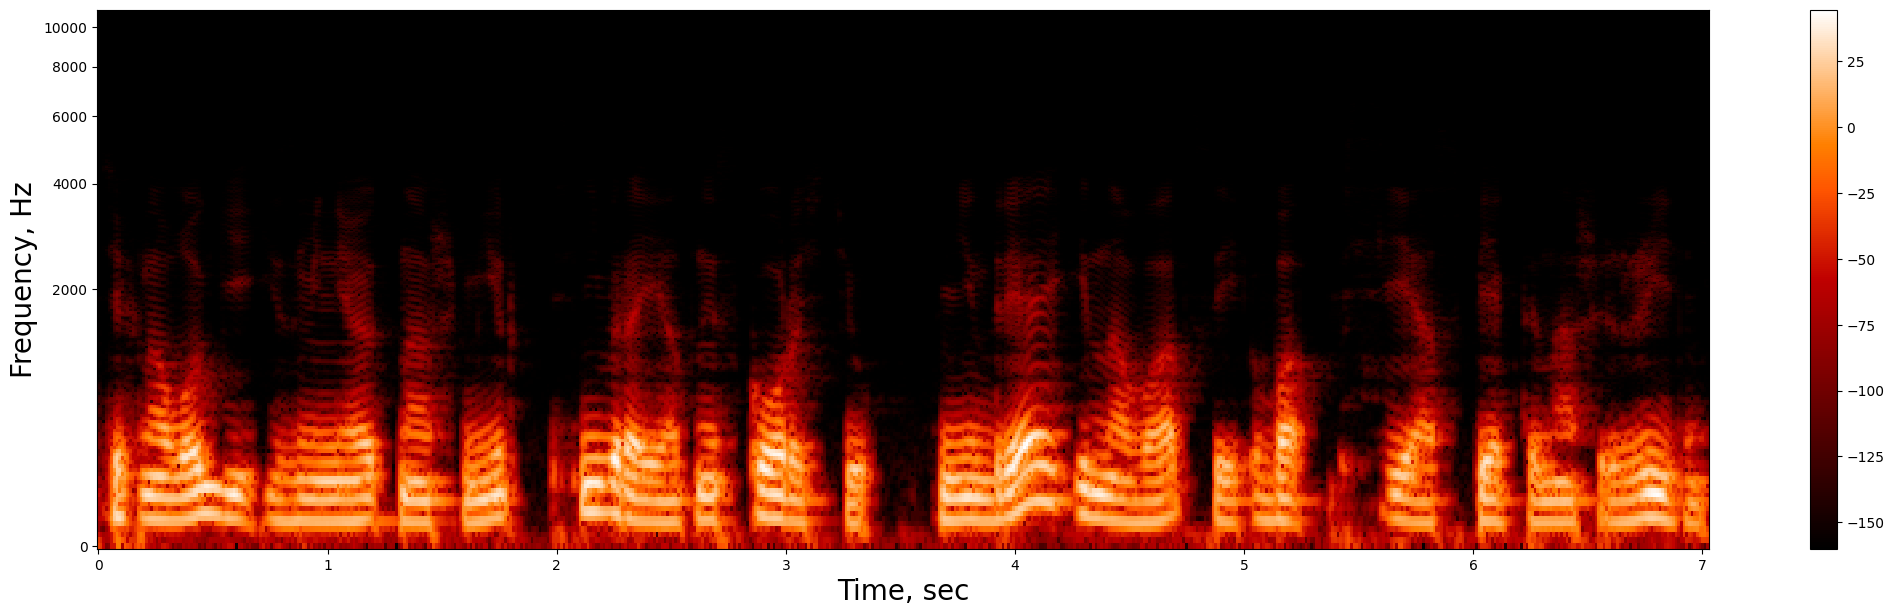

In [80]:
f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,wavLPSpec.shape[2]*hopSize, hopSize)/sr
fGrid = freqsR
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff,20*torch.log10(wavLPSpec.squeeze()+1e-8),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, Hz', size=20)
ax.set_yscale("function",functions=(melForward,melInverse))
f.colorbar(im)
plt.show()

##### High-Pass

Leaves higher frequencies(above cutoff) intact while supressing lower frequencies(below cutoff).

Оставляет нетронутыми высокие частоты (выше среза), подавляя при этом низкие частоты (ниже среза).

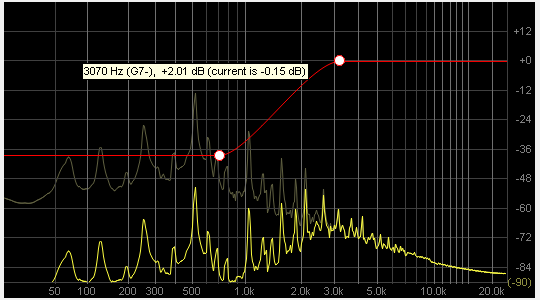

In [86]:
freqsR = np.arange(0,nFFT/2+0.0001)/(nFFT)*sr
highPassFilter = tf.HighPass(1000,sr)
wavHP = highPassFilter(wav)
wavHPSpec = specTransform(wavHP)

In [87]:
display.display(display.Audio(wavHP, rate=sr))

/tmp/ipykernel_19621/4130932232.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595*np.log10(1 + f/700) #wikipedia suggestion


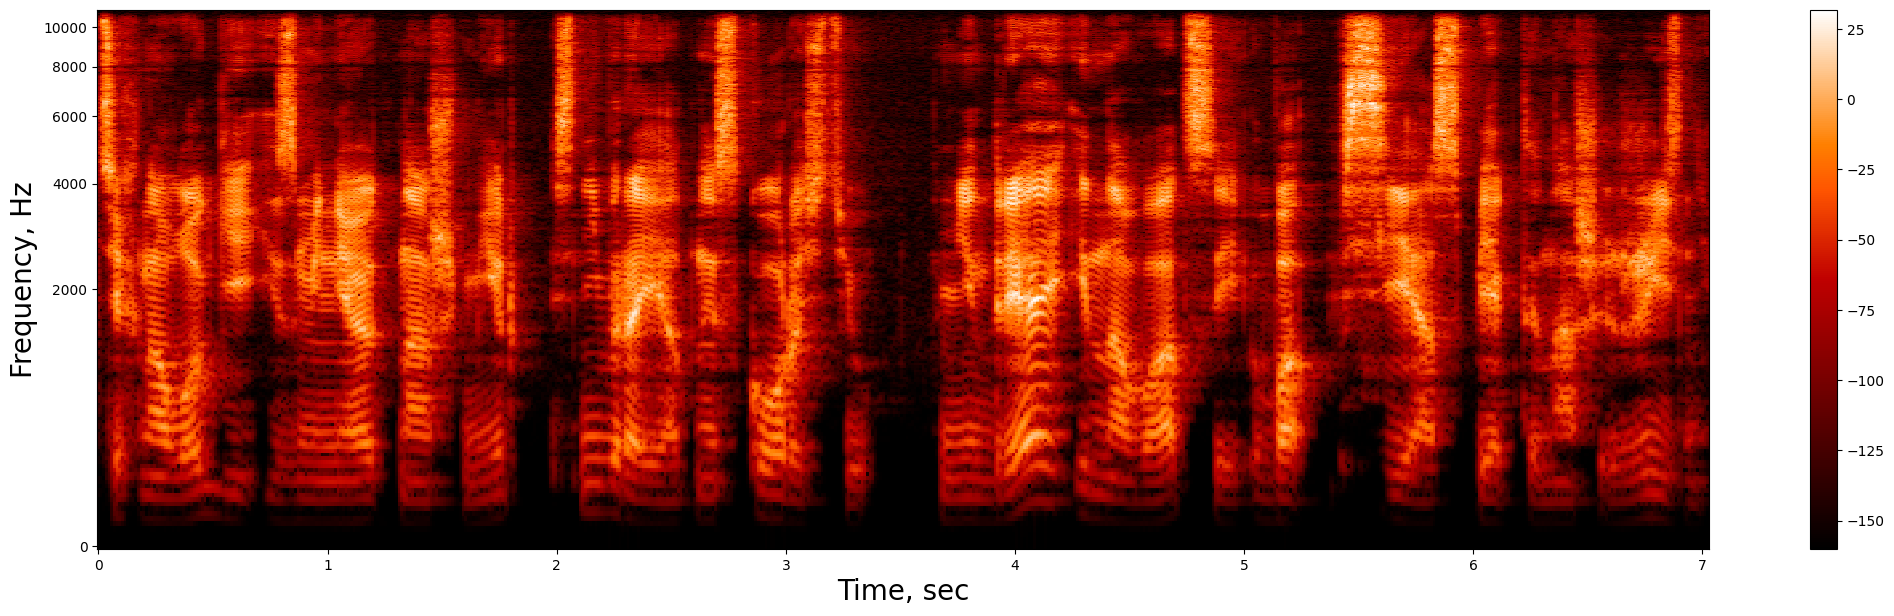

In [88]:
f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,wavHPSpec.shape[2]*hopSize, hopSize)/sr
fGrid = freqsR
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff,20*torch.log10(wavHPSpec.squeeze()+1e-8),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, Hz', size=20)
ax.set_yscale("function",functions=(melForward,melInverse))
f.colorbar(im)
plt.show()

##### Band-Pass

Combines Low-Pass and High-Pass filters.

Комбинирует низкочастотный и высокочастотный фильтры.

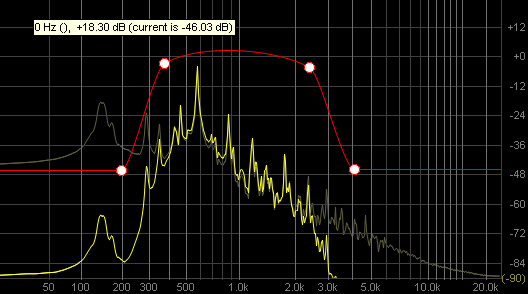

In [91]:
freqsR = np.arange(0,nFFT/2+0.0001)/(nFFT)*sr
bandPassFilter = tf.BandPass(500, 1000,sr)
wavBP = bandPassFilter(wav)
wavBPSpec = specTransform(wavBP)

In [92]:
display.display(display.Audio(wavBP, rate=sr))

/tmp/ipykernel_19621/4130932232.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595*np.log10(1 + f/700) #wikipedia suggestion


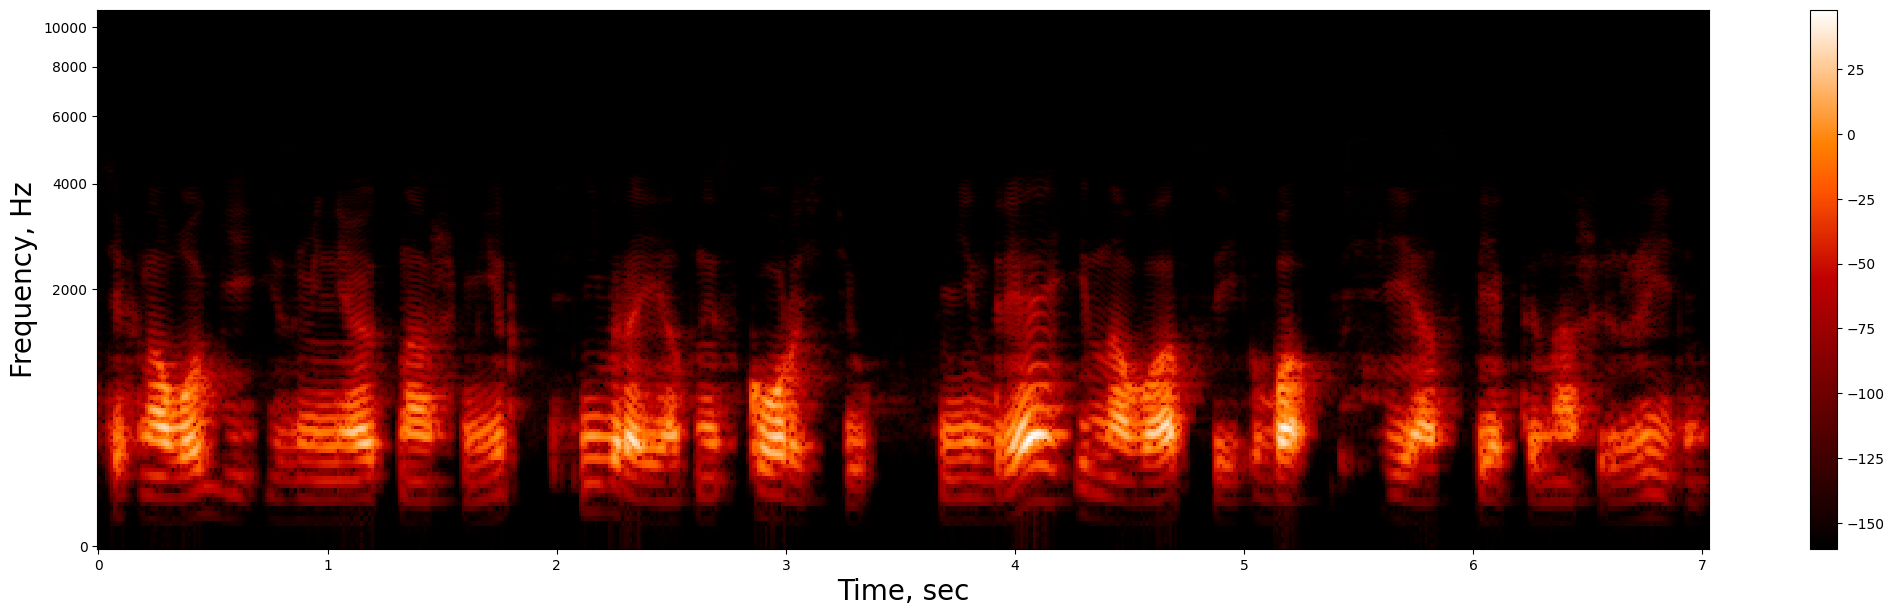

In [93]:
f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,wavBPSpec.shape[2]*hopSize, hopSize)/sr
fGrid = freqsR
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff,20*torch.log10(wavBPSpec.squeeze()+1e-8),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, Hz', size=20)
ax.set_yscale("function",functions=(melForward,melInverse))
f.colorbar(im)
plt.show()